<a href="https://colab.research.google.com/github/gomes-lab/course-cs2770-2024sp/blob/main/colab-notebooks/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
'''
Run this cell to import the necessary packages
'''
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import urllib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
plt.rcParams.update({'font.size': 14})
import warnings
warnings.filterwarnings('ignore')

In [7]:
# -------------------------------------------------------------
# Load Data
#
# training_data - subset of the data used to train, or fit
# the the predictive models
# test_data - subset of the data used to indepently
# assess the model
# map_data - this data set includes all of the predictors
# evaluated across a regular grid of locations
# that covers the study area.
# -------------------------------------------------------------
url_train='https://raw.githubusercontent.com/gomes-lab/course-cs2770-2024sp/main/data/L21_Wood_Thrush_train.data.CSV'
url_test= 'https://raw.githubusercontent.com/gomes-lab/course-cs2770-2024sp/main/data/L21_Wood_Thrush_test.data.CSV'
url_map='https://raw.githubusercontent.com/gomes-lab/course-cs2770-2024sp/main/data/L21_Wood_Thrush_map.data.CSV'
train_data= pd.read_csv(url_train)
test_data=pd.read_csv(url_test)
map_data=pd.read_csv(url_map)

# -------------------------------------------------------------
# Look at the data structure
# -------------------------------------------------------------
train_data.head() #print out the first few lines of the csv file

,I.STATIONARY,YEAR,DAY,TIME,EFFORT_HRS,EFFORT_DISTANCE_KM,NUMBER_OBSERVERS,ELEVATION,Water,Evergreen_Needleleaf,...,Open_shrublands,Woody_savannas,Savannas,Grasslands,Croplands,Urban,Barren,LONGITUDE,LATITUDE,y
0,1,2013,195,20.00,0.167,0.000,1,249,0.0,0.0,...,0.0,0.0000,0.0000,5.5556,11.1111,63.8889,0,-76.482475,42.447497,0
1,0,2013,201,9.73,0.833,1.996,1,318,0.0,0.0,...,0.0,0.0000,0.0000,8.3333,50.0000,0.0000,0,-76.462876,42.481421,0
2,1,2013,187,6.05,0.083,0.000,1,310,0.0,0.0,...,0.0,2.7778,0.0000,8.3333,41.6667,0.0000,0,-76.463070,42.478690,0
3,0,2013,169,15.42,2.933,5.150,1,275,0.0,0.0,...,0.0,2.7778,0.0000,0.0000,0.0000,2.7778,0,-76.463390,42.407110,1
4,0,2013,177,7.17,0.567,1.770,1,366,0.0,0.0,...,0.0,2.7778,5.5556,0.0000,27.7778,0.0000,0,-76.390214,42.691647,1


(-76.728889, -76.22032, 42.267762, 42.69165)


(42.267762, 42.69165)

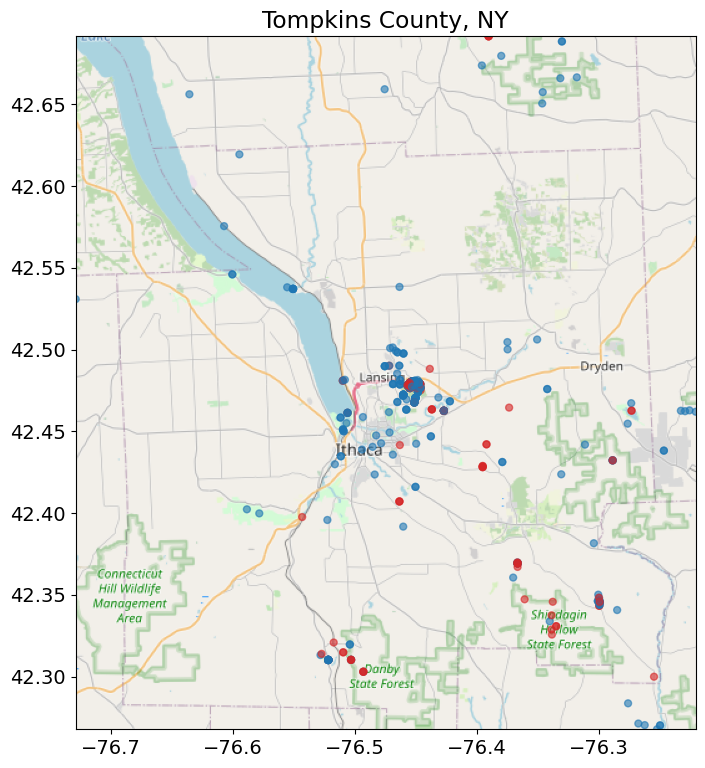

In [8]:
# -------------------------------------------------------------
# 1 Initial Data Analysis
# --------------------------------------------------------------
# --------------------------------------------------------------
# 1A: Plot the locations of the data
# --------------------------------------------------------------
#First find the boundaries of the map
BBox = ((train_data.LONGITUDE.min(),   train_data.LONGITUDE.max(),
         train_data.LATITUDE.min(), train_data.LATITUDE.max()))
print(BBox)
#We exported a map within the bounding box from OpenStreetMap
#Load the map
url = 'https://github.com/gomes-lab/course-cs2770-2024sp/blob/main/data/map_of_ithaca_small.png?raw=true'
ithaca_map = np.array(PIL.Image.open(urllib.request.urlopen(url)))
#set the colors of the dots
set_color=lambda x : '#d62728' if (x==1) else '#1f77b4'
color=[set_color(x) for x in train_data.y]
fig, ax = plt.subplots(figsize = (8,9))
plt.rcParams.update({'font.size': 14})
#plot the map under the scatter points
ax.imshow(ithaca_map,extent = BBox,aspect='auto')
ax.scatter(train_data.LONGITUDE, train_data.LATITUDE, c=color, alpha=0.6, s=25)
ax.set_title('Tompkins County, NY')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

['ELEVATION', 'Water', 'Evergreen_Needleleaf', 'Evergreen_Broadleaf', 'Deciduous_Needleleaf', 'Deciduous_Broadleaf', 'Mixed', 'Closed_shrublands', 'Open_shrublands', 'Woody_savannas', 'Savannas', 'Grasslands', 'Croplands', 'Urban', 'Barren']


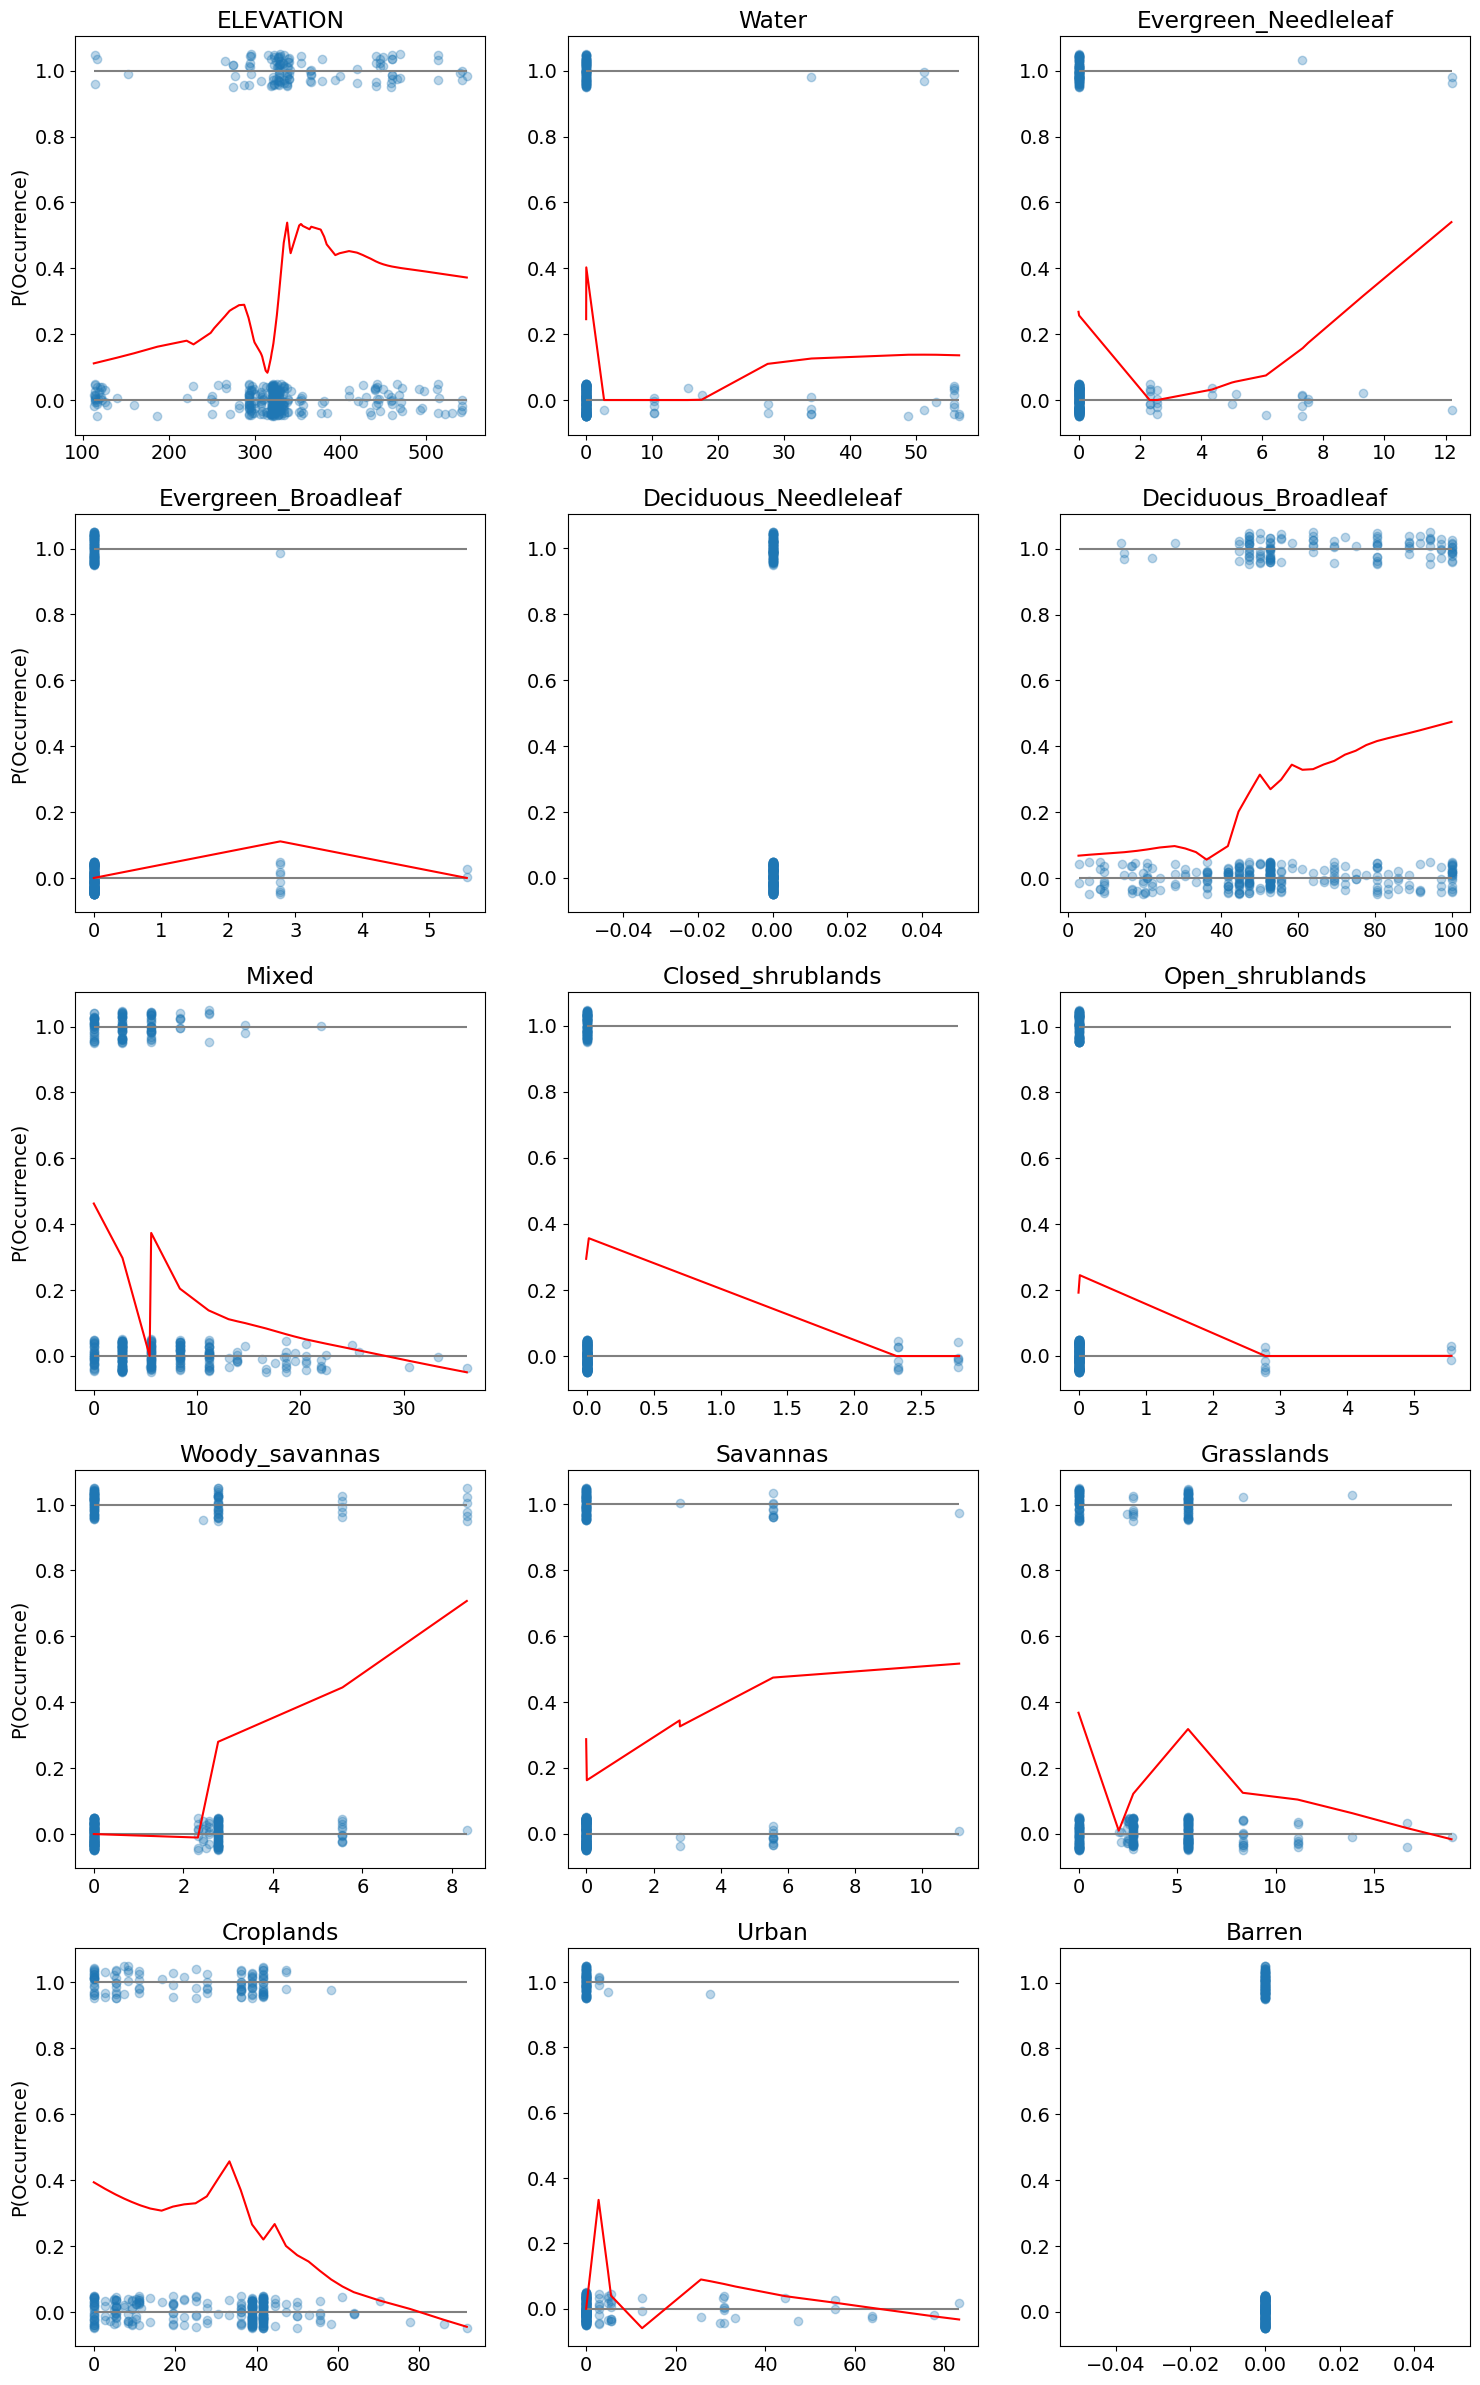

In [9]:
# --------------------------------------------------------------
# 1B: Occurrence-Landcover Scatterplots.
# --------------------------------------------------------------
#print the names of the predictors
feature_list=list(train_data.columns[7:22])
print(feature_list)
#set up the subplots
fig, axs = plt.subplots(5, 3,figsize=(18,30))
axs = axs.flatten()
idx=0
for predictor in feature_list:
    #jitter the data points
    jittered_y = train_data.y+np.random.uniform(-0.05, 0.05, train_data.y.shape)
    #compute the lowess, iter=0 is important for binary data!
    if predictor in ['Water', 'Evergreen_Needleleaf' ,'Closed_shrublands','Open_shrublands','Savannas','Woody_Savannas']:
        # need to use jittered_x to compute lowess for these predictors
        # otherwise the outputs contain NaNs
        jittered_x=train_data[predictor]+np.random.uniform(-0.01, 0.01, train_data.y.shape)
        z=sm.nonparametric.lowess(train_data.y, jittered_x,frac=0.5,it=0,delta=0.05)
    else:
      z=sm.nonparametric.lowess(train_data.y, train_data[predictor],frac=0.5,it=0,delta=0.05)
    #plot in one of the subplots
    axs[idx].scatter(train_data[predictor], jittered_y, alpha=0.3)
    if idx in [0,3,6,9,12]:
        axs[idx].set_ylabel('P(Occurrence)')
    axs[idx].set_title(predictor)
    axs[idx].hlines([0,1],train_data[predictor].min(),train_data[predictor].max(),'grey')
    axs[idx].plot(z[:,0],z[:,1],'r')
    idx+=1

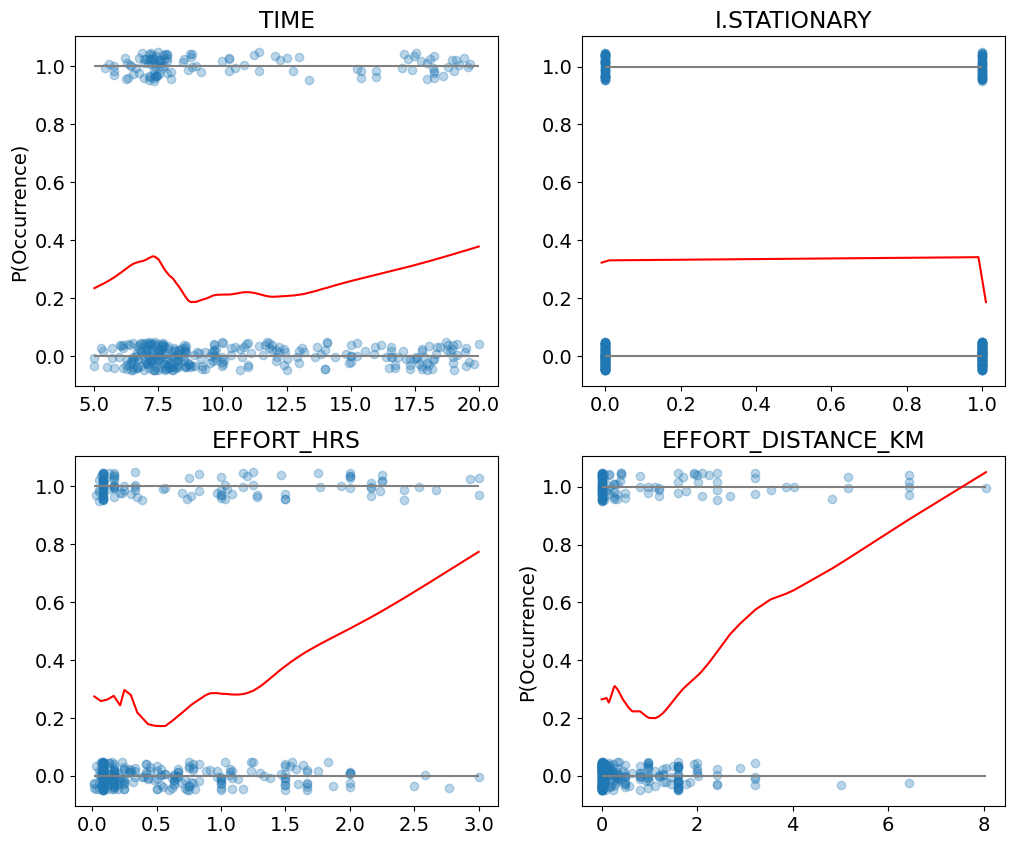

In [10]:
# --------------------------------------------------------------
# 1C: Occurrence-Observation Predictor (and Elevation!) Scatterplots.
# --------------------------------------------------------------
#print the names of the predictors
feature_list = ['TIME', 'I.STATIONARY','EFFORT_HRS', 'EFFORT_DISTANCE_KM']
#set up the subplots
fig, axs = plt.subplots(2, 2,figsize=(12,10))
axs = axs.flatten()
idx=0
for predictor in feature_list:
    #jitter the data points
    jittered_y = train_data.y+np.random.uniform(-0.05, 0.05, train_data.y.shape)
    #compute the lowess, iter=0 is important for binary data!
    if predictor == 'I.STATIONARY':
        # need to use jittered_x to compute lowess for these predictors
        # otherwise the outputs contain NaNs
        jittered_x=train_data[predictor]+np.random.uniform(-0.01, 0.01, train_data.y.shape)
        z=sm.nonparametric.lowess(train_data.y, jittered_x,frac=0.5,it=0,delta=0.05)
    else:
      z=sm.nonparametric.lowess(train_data.y, train_data[predictor],frac=0.5,it=0,delta=0.05)
    #plot in one of the subplots
    axs[idx].scatter(train_data[predictor], jittered_y, alpha=0.3)
    if idx in [0,3,6,9,12]:
        axs[idx].set_ylabel('P(Occurrence)')
    axs[idx].set_title(predictor)
    axs[idx].hlines([0,1],train_data[predictor].min(),train_data[predictor].max(),'grey')
    axs[idx].plot(z[:,0],z[:,1],'r')
    idx+=1

In [11]:
# --------------------------------------------------------------
# 2 Random Forest Model
# -------------------------------------------------------------
# n_jobs is the number of jobs to run in parallel
rf = RandomForestRegressor(n_estimators=100, n_jobs=8)
# fit the data; remember to remove the 'y' column from training data
# also removed LONGITUDE and LATITUDE to force the model to learn habitat associations
# instead of spatial associations
rf.fit(train_data[train_data.columns[0:22]],train_data.y)

RandomForestRegressor(n_jobs=8)

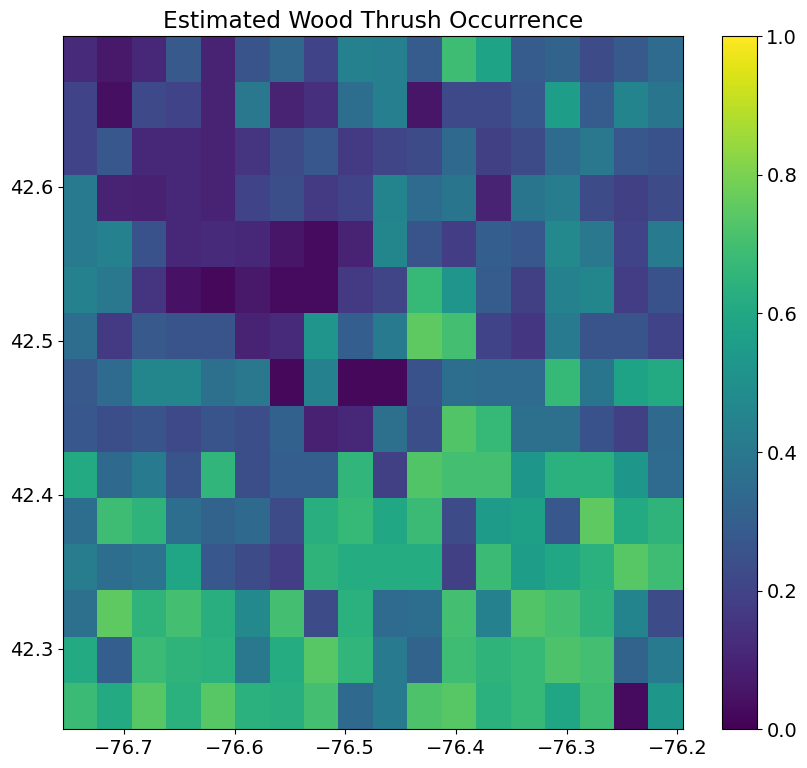

In [12]:
# -------------------------------------------------------------
# 2B: Occurrence Map
# --------------------------------------------------------------
# Set these variables to constant values to remove variation in observation process
map_data['EFFORT_HRS'] = 1
map_data['EFFORT_DISTANCE_KM'] = 1
map_data['TIME'] = 7
map_data['DAY'] = 182
map_data['YEAR'] = 2016
# make sure the sequence of the columns is the same as train_data
pred_map_rf =rf.predict(map_data[train_data.columns[0:22]])
# create an array of the occurrence rate
nrow=15
ncol=18
occurrence_array=np.zeros((nrow,ncol))
# compute the boundaries of the map
grid_size_h=(map_data.LONGITUDE.max()-map_data.LONGITUDE.min())/(ncol-1)
grid_size_v=(map_data.LATITUDE.max()-map_data.LATITUDE.min())/(nrow-1)
BBox = ((map_data.LONGITUDE.min()-grid_size_h/2,   map_data.LONGITUDE.max()+grid_size_h/2,
         map_data.LATITUDE.min()-grid_size_v/2, map_data.LATITUDE.max()+grid_size_v/2))
# compute the column and row number of each grid
col_idx=np.array((map_data.LONGITUDE-map_data.LONGITUDE.min())/(map_data.LONGITUDE.max()-map_data.LONGITUDE.min())*(ncol-1))
row_idx=np.array((map_data.LATITUDE.max()-map_data.LATITUDE)/(map_data.LATITUDE.max()-map_data.LATITUDE.min())*(nrow-1))
for i in range(len(row_idx)):
    occurrence_array[int(row_idx[i]+0.01)][int(col_idx[i]+0.01)]=pred_map_rf[i]

# plot the quilt map of predictions
plt.figure(figsize = (10,9))
plt.imshow(occurrence_array,cmap='viridis',extent = BBox, aspect = 'auto')
plt.clim((0,1))
plt.colorbar()
plt.title('Estimated Wood Thrush Occurrence')
plt.show()

In [13]:
# -------------------------------------------------------------
# Lets Compare with this Logisitic Regression Model
# --------------------------------------------------------------
d=smf.glm(formula = 'y ~ Deciduous_Broadleaf + EFFORT_DISTANCE_KM',
               family=sm.families.Binomial(),
               data=train_data).fit()
print(d.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  407
Model:                            GLM   Df Residuals:                      404
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -225.27
Date:                Thu, 25 Apr 2024   Deviance:                       450.53
Time:                        00:04:21   Pearson chi2:                     401.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08450
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.3884    

In [14]:
# --------------------------------------------------------------
# Predictive Performance Assessment
# -------------------------------------------------------------
#ground truth
yyy=np.array(test_data.y)
#prediction of the two models
test_pred=d.predict(test_data)
test_pred2=rf.predict(test_data[train_data.columns[0:22]])

print('MSE of logistic regression model:', np.mean((yyy-test_pred)**2))
print('MSE of random forest model:', np.mean((yyy-test_pred2)**2))
# remove 0 and 1 from the vectors to avoid errors in computation
test_pred=np.where(test_pred == 0 , 0.01, test_pred)
test_pred=np.where(test_pred == 1 , 0.99, test_pred)
test_pred2=np.where(test_pred2 == 0 , 0.01, test_pred2)
test_pred2=np.where(test_pred2 == 1 , 0.99, test_pred2)
print('Log-loss of logistic regression model:', np.sum(yyy*np.log(test_pred) + (1-yyy)*np.log(1-test_pred)))
print('Log-loss of random forest model:', np.sum(yyy*np.log(test_pred2) + (1-yyy)*np.log(1-test_pred2)))
print('AUC score of logistic regression model:', roc_auc_score(test_data.y,test_pred))
print('AUC score of random forest model:', roc_auc_score(test_data.y,test_pred2))

MSE of logistic regression model: 0.17269876577895465
MSE of random forest model: 0.1507397590361446
Log-loss of logistic regression model: -216.2686701386857
Log-loss of random forest model: -191.60895995113444
AUC score of logistic regression model: 0.7089254662109492
AUC score of random forest model: 0.808658631648378


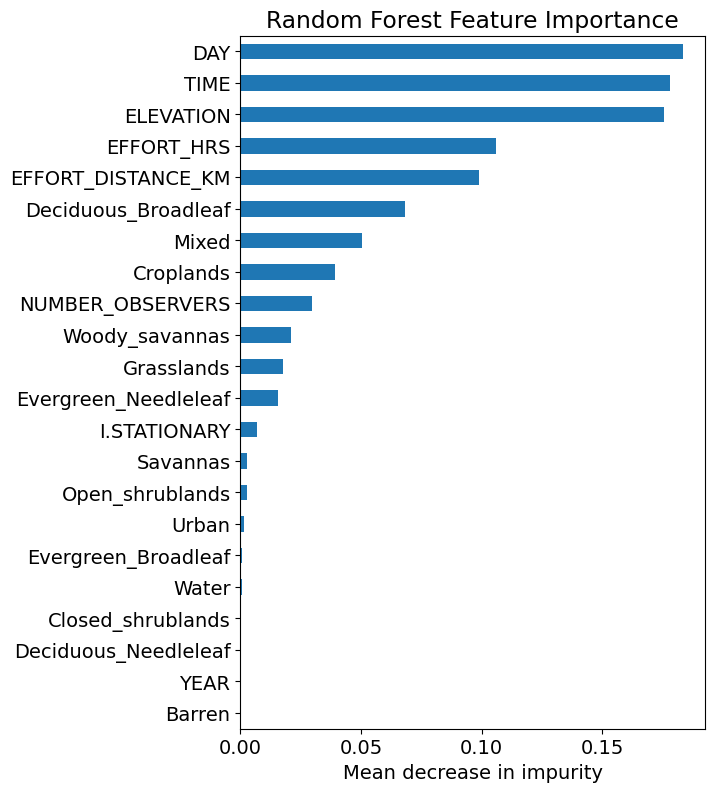

In [15]:
# -------------------------------------------------------------
# Compute & plot the feature importances from Random Forests
# -------------------------------------------------------------
# compute the feature importances
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=train_data.columns[0:22])
# sort the features based on their importance
forest_importances = forest_importances.sort_values()
# plot the feature importances
plt.figure(figsize=(6,9))
forest_importances.plot.barh()
plt.title("Random Forest Feature Importance")
plt.xlabel("Mean decrease in impurity")
fig.tight_layout()